In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh

from pygimli.physics import TravelTimeManager

[16.16727386  0.3144482   2.        ]


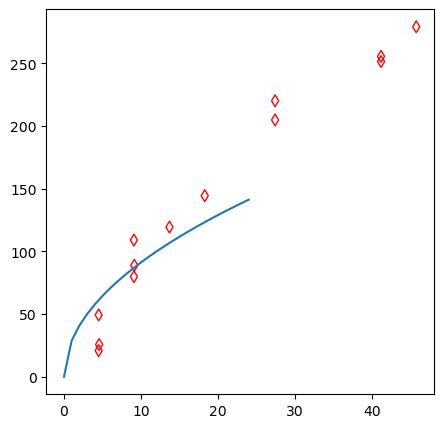

In [52]:
from scipy.optimize import curve_fit

def first_layer_vel_eq(Z, V0, Z0, E):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = V0 * (abs(Z)/Z0)**(1/E)
    return vel

offset_cutoff_idx = 8  # how many data points are in shallow layer +1
xdata = ap14_vels[:offset_cutoff_idx,0]
ydata = ap14_vels[:offset_cutoff_idx,1]

popt, pcov = curve_fit(first_layer_vel_eq, xdata, ydata,
                      bounds=([0.,0.,2.],[np.inf, np.inf, 6.]))

print(popt)


xplot = np.arange(0,25)
vels = []
for z in xplot:
    vel = first_layer_vel_eq(z, popt[0], popt[1], popt[2])
    vels.append(vel)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False)
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='d', edgecolors='red', 
           facecolors='None', label='Martella')

ax.plot(xplot, vels)

plt.show()


12/09/22 - 21:31:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 7) to solve forward task.


Raytracing with 7 secondary nodes: Elapsed time is 13.06 seconds.


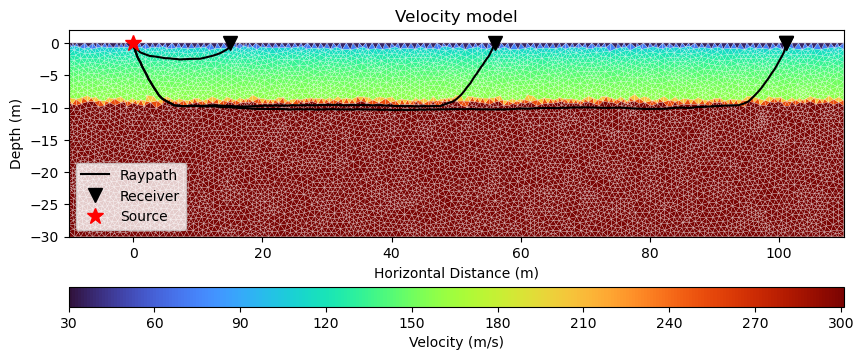

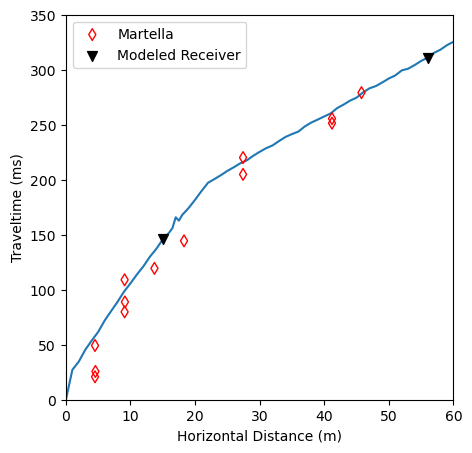

In [68]:
##~~~~~~~~~~~~~~~~~
## Generate the mesh


def first_layer_vel(node):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = 55 * (abs(node.y())/0.015)**(1/6.)
    return vel

second_layer_depth = 9
second_layer_velocity = 300.




sensors = np.arange(110, step=1.)
plc = mt.createWorld([-10, -30], [110, 0], worldMarker=False)
for pos in sensors:
    plc.createNode([pos, 0.0])
mesh_gradient = mt.createMesh(plc, quality=33, area=0.5, smooth=[1,10])


vel_gradient = []
for node in mesh_gradient.nodes():
    
    if node.y() < -1*second_layer_depth:
        vel_gradient.append(second_layer_velocity)
    else:
        vel_gradient.append(first_layer_vel(node))
    
    
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient,
                                               np.array(vel_gradient))



##~~~~~~~~~~~~~~~~~
## Raytrace Plot

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for boundary in mesh_gradient.boundaries():
    boundary.setMarker(0)

xmin, xmax = mesh_gradient.xmin(), mesh_gradient.xmax()
mesh_gradient.createNeighborInfos()

# In order to use the Dijkstra, we extract the surface positions >0
mx = pg.x(mesh_gradient)
my = pg.y(mesh_gradient)
px = np.sort(mx[my == 0.0])

# A data container with index arrays named s (shot) and g (geophones) is
# created and filled with the positions and shot/geophone indices.
data = pg.DataContainer()
data.registerSensorIndex('s')
data.registerSensorIndex('g')

for i, pxi in enumerate(px):
    data.createSensor([pxi, 0.0])
    if pxi == 0.0:
        source = i

nData = len(px)
data.resize(nData)
data['s'] = [source] * nData # only one shot at first sensor
data['g'] = range(nData)  # and all sensors are receiver geophones

# Draw initial mesh with velocity distribution
vel_plot, cb = pg.show(mesh_gradient, vel_gradient, ax=ax, label="Velocity (m/s)", hold=True,
        logScale=False, cMap="turbo", coverage=None)
drawMesh(ax, mesh_gradient, color="white", lw=0.21)

# We compare the accuracy for 0-5 secondary nodes
sec_nodes = [7]
t_all = []
durations = []
paths = []

mgr = TravelTimeManager()

cols = ['black', 'red','blue']
recs = [15, 56, 101]

for i, n in enumerate(sec_nodes):

    # Perform traveltime calculations and log time with pg.tic() & pg.toc()
    pg.tic()
    res = mgr.simulate(vel=vel_gradient, scheme=data, mesh=mesh_gradient, secNodes=n)
    # We need to copy res['t'] here because res['t'] is a reference to
    # an array in res, and res will be removed in the next iteration.
    # Unfortunately, we don't have any reverence counting for core objects yet.
    t_all.append(res['t'].array())
    durations.append(pg.dur())
    pg.toc("Raytracing with %d secondary nodes:" % n)

    for r, p in enumerate(recs):
        if r == 0:
            lab = "Raypath"
        else:
            lab = None

        recNode = mgr.fop.mesh().findNearestNode([sensors[p], 0.0])
        sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])

        path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
        points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
        ax.plot(points[:,0], points[:,1], cols[i], label=lab)


        
        


# Draw sensor positions for the selected receivers
for p in recs:
    ax.plot(sensors[p], 0.0, "kv", ms=10)
ax.plot(sensors[p], 0.0, "kv", ms=10, label='Receiver')  # double plotting last one for the label
ax.plot(0.0, 0.0, "r*", ms=12, label='Source')
ax.set_ylim(mesh_gradient.ymin(), 2)

## Control the colorbar in the plot
min_c = 30
max_c = 301
tick_increment = 30
ticks = np.arange(min_c, max_c, tick_increment)
cb.mappable.set_clim(min_c, max_c)
cb.ax.xaxis.set_ticks(ticks)
# cb.solids.set_edgecolor("face")  # gets rid of weird lines

ax.set_title("Velocity model")
ax.set_xlabel("Horizontal Distance (m)")
ax.legend()
ax.set_ylabel("Depth (m)")
plt.show()



##~~~~~~~~~~~~~~~~~
## Traveltime Plot
vel_data_path = './Martella_Apollo14_Picks.txt'
ap14_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=4, encoding='utf-8')


fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False)
for i, n in enumerate(sec_nodes):
    ax.plot(px, t_all[i] * 1000, zorder=1)
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='d', edgecolors='red', 
           facecolors='None', label='Martella', zorder=2)

gidxs = []
for p in recs:
    curr_gidx = (np.abs(px - p)).argmin()
    gidxs.append(curr_gidx)
ax.scatter(px[gidxs], t_all[0][gidxs] * 1000, marker='v', c='black', s=50,
          label='Modeled Receiver', zorder=3)

ax.set_ylabel("Traveltime (ms)")
ax.set_xlabel("Horizontal Distance (m)")
ax.legend()
plt.xlim(0,60)
plt.ylim(0,350)
plt.show()